In [2]:
from skimage import io, transform
import numpy as np

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [57]:
# # utilities
# from io import StringIO
# from IPython.display import clear_output, Image, display
# import PIL.Image

# def show_img_array(a, fmt='jpeg'):
#     a = np.uint8(np.clip(a, 0, 255))
#     f = StringIO()
#     PIL.Image.fromarray(a).save(f, fmt)
#     display(Image(data=f.getvalue()))

In [11]:
# load U2NET Model
from model import U2NETP # small version u2net 4.7 MB

model_name='u2netp'
model_dir = './saved_models/'+ model_name + '/' + model_name + '.pth'

image_size = 320 # input image size for the model

# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

# load model
net = U2NETP(3,1)
net.load_state_dict(torch.load(model_dir))
if torch.cuda.is_available():
    net.cuda()
net.eval()
print("model loaded")

model loaded


In [48]:
def rescale(image, output_size):
    h, w = image.shape[:2]

    if h > w:
        new_h, new_w = output_size*h/w, output_size
    else:
        new_h, new_w = output_size, output_size*w/h

    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(image,(output_size, output_size),mode='constant')
    return img

# change the r,g,b to b,r,g from [0,255] to [0,1]
#transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
def normalize(image):
    tmpImg = np.zeros((image.shape[0],image.shape[1],3))
    
    if image.shape[2]==1:
        tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
        tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
        tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
    else:
        tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
        tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
        tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225
        
    tmpImg = tmpImg.transpose((2, 0, 1))
    return tmpImg

In [62]:
def process_image(img):
    # preprocess
    img = normalize(rescale(img, image_size))
    
    # numpy -> torch
    inputs_test = torch.from_numpy(np.array([img]))
    inputs_test = inputs_test.type(torch.FloatTensor)

    if torch.cuda.is_available():
        inputs_test = Variable(inputs_test.cuda())
    else:
        inputs_test = Variable(inputs_test)

    # process!
    d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

    # normalization
    pred = d1[:,0,:,:]
    pred = normPRED(pred)
    
    # back to numpy
    pred = pred.cpu().data.numpy()
    
    # back to 3 channel
    pred = np.repeat(pred, 3, axis=0)
    pred =pred.transpose(1, 2, 0)

    return pred

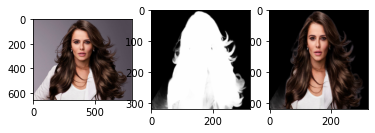

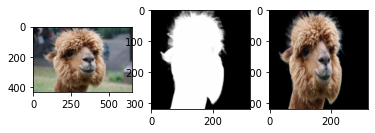

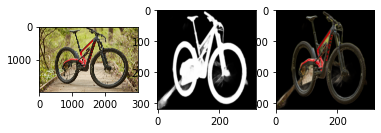

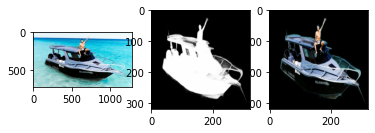

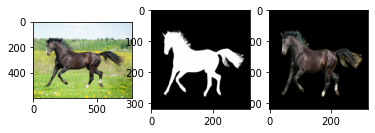

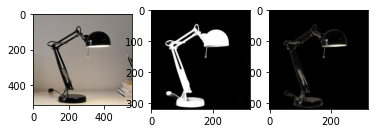

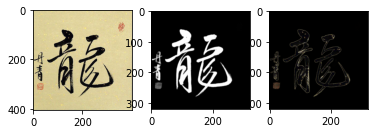

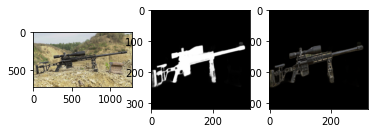

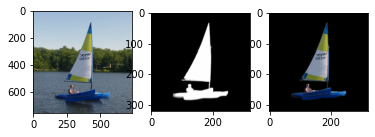

In [63]:
from glob import glob 
import matplotlib.pyplot as plt

for imgpath in glob("./test_data/test_images/*.jpg")[:10]:
    img = io.imread(imgpath)
    # original
    fig = plt.figure()
    fig.add_subplot(1, 3, 1)
    plt.imshow(img)

    # segmentation 
    seg_img = process_image(img)
    fig.add_subplot(1, 3, 2)
    plt.imshow(seg_img)
    #io.imshow(masked_img)

    # mask
    img = rescale(img, image_size)
    masked = img * seg_img
    fig.add_subplot(1, 3, 3)
    plt.imshow(masked)
    plt.show()
    print("")

# of files 68


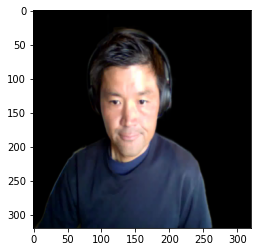

In [79]:
filepaths = glob("./test_data/video_frames/*.jpg")
print("# of files", len(filepaths))

for index, imgpath in enumerate(filepaths):
    img = io.imread(imgpath)
    seg_img = process_image(img.copy())

    img = rescale(img, image_size)  
    masked = img * seg_img
    plt.imshow(masked)
    masked = (masked * 255).astype(np.uint8)
    io.imsave("./test_data/video_frames/output/frame-%03d.jpg" % index, masked)

In [82]:
!ffmpeg -r 10 -i test_data/video_frames/output/frame-%03d.jpg -vcodec mpeg4 -y test_data/video_frames/output/movie.mp4

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [86]:
from IPython.display import Video

Video("./test_data/video_frames/output/movie.mp4")